### Обучение на базе многообразий (manifold learning)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#### Обучение на базе многообразий: HELLO

In [2]:
# сгенерим двумерные данные
def make_hello(N=1000, rseed=42):
    fig, ax = plt.subplots(figsize=(4,1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold',
           size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    #  Открываем этот PNG-файл и берем из него случайные точки 
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i,j] < 1)
    X = X[mask]
    X[:,0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:,0])]

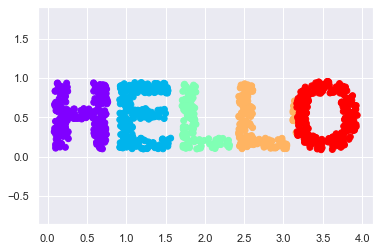

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:,0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:,0], X[:,1], **colorize)
plt.axis('equal');

#### Многомерное масштабирование (MDS) 

In [4]:
# повернем данные
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]]
    return np.dot(X,R)

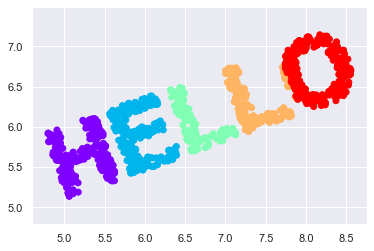

In [5]:
X2 = rotate(X,20) + 5
plt.scatter(X2[:,0], X2[:,1], **colorize)
plt.axis('equal');

In [6]:
X.shape

(1000, 2)

In [7]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

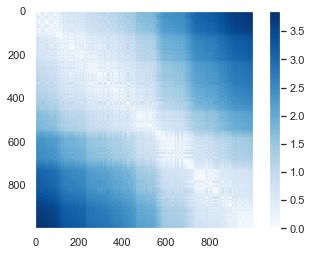

In [8]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

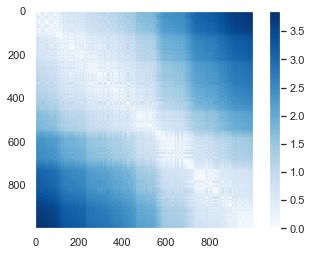

In [9]:
D2 = pairwise_distances(X2)
plt.imshow(D2, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [10]:
np.allclose(D,D2)

True

(-1.0390064107727583,
 1.0377133989963179,
 -2.0646660054511314,
 2.135458244484913)

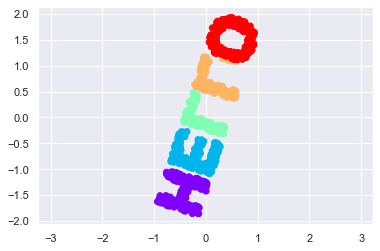

In [11]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed',
           random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:,0], out[:,1], **colorize)
plt.axis('equal')

#### MDS как обучение на базк многообразий

In [12]:
# вращение в 3-мерном пространстве
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1] #проверка истинности указанного утверждения
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

In [13]:
X3 = random_projection(X,3)
X3.shape

(1000, 3)

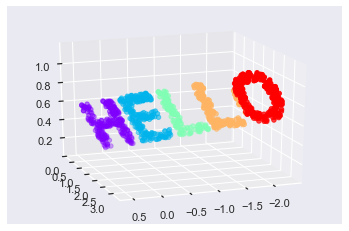

In [14]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:,0], X3[:,1], X3[:,2],
            **colorize)
ax.view_init(azim=70, elev=20)

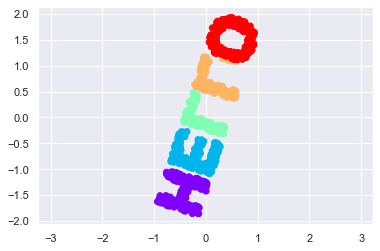

In [15]:
# передадим данные оценивателю для вычисления матрицы расстояний 
# и последующего определения оптимального двумерного вложения для нее
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out[:,0], out[:,1], **colorize)
plt.axis('equal');

In [16]:
X

array([[0.08373647, 0.31577315],
       [0.08729359, 0.66378969],
       [0.08849421, 0.32361022],
       ...,
       [3.92447163, 0.64950893],
       [3.92503031, 0.3816165 ],
       [3.93760872, 0.52569018]])

### Нелинейные вложения: там, где MDS не работает

In [17]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T 

In [18]:
XS = make_hello_s_curve(X)

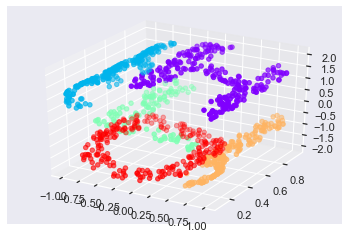

In [20]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:,0], XS[:,1], XS[:,2], **colorize);

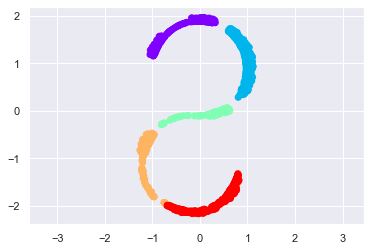

In [21]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)        
plt.scatter(outS[:, 0], outS[:, 1], **colorize)        
plt.axis('equal');


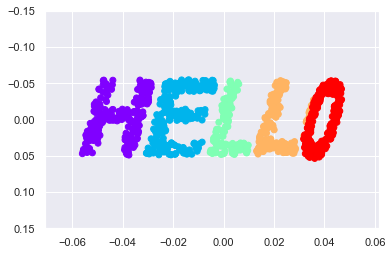

In [30]:
from sklearn.manifold import LocallyLinearEmbedding 
model = LocallyLinearEmbedding(n_neighbors=110, n_components=2, method='modified',
                               eigen_solver='dense') 
out = model.fit_transform(XS)
fig, ax = plt.subplots() 
ax.scatter(out[:, 0], out[:, 1], **colorize) 
ax.set_ylim(0.15, -0.15);

#### Пример: использование Isomap для распознавания лиц


In [31]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

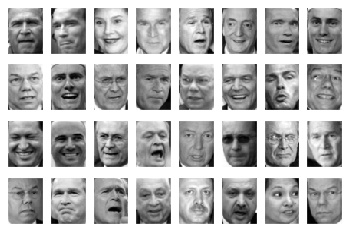

In [37]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

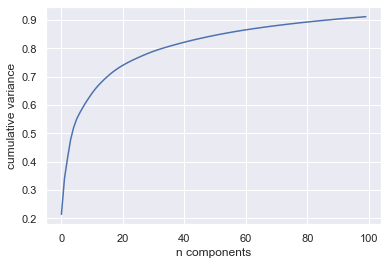

In [40]:
from sklearn.decomposition import PCA as RandomizedPCA        
model = RandomizedPCA(100).fit(faces.data)        
plt.plot(np.cumsum(model.explained_variance_ratio_))        
plt.xlabel('n components')         # Количество компонент        
plt.ylabel('cumulative variance'); # Интегральная дисперсия

In [41]:
from sklearn.manifold import Isomap        
model = Isomap(n_components=2)        
proj = model.fit_transform(faces.data)        
proj.shape


(2370, 2)

In [43]:
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'): 
    ax = ax or plt.gca()
    proj = model.fit_transform(data) 
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - 
                                       proj.min(0))) ** 2 
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]): 
            dist = np.sum((proj[i] - shown_images) ** 2, 1) 
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap),
                                                proj[i]) 
            ax.add_artist(imagebox) 

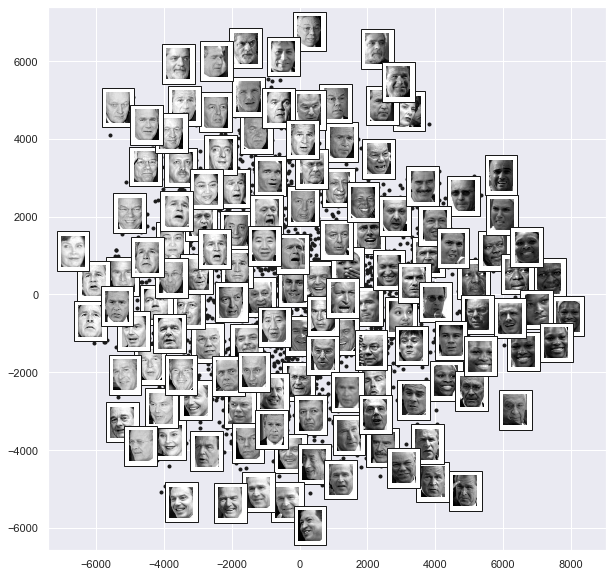

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))        
plot_components(faces.data, model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])


#### Пример: визуализация структуры цифр 

In [45]:
from sklearn.datasets import fetch_mldata

In [49]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [50]:
mnist.data.shape

(70000, 784)

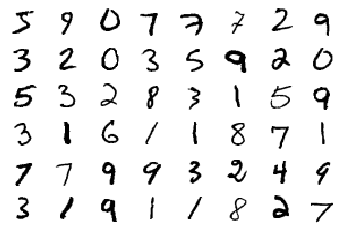

In [56]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))        
for i, axi in enumerate(ax.flat):            
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')


In [94]:
# используем только 1/30 часть данных: 
data = mnist.data[::30] 
target = mnist.target[::30]


In [95]:
model = Isomap(n_components=2) 
proj = model.fit_transform(data) 

In [96]:
proj.shape

(2334, 2)

In [97]:
proj += (-np.min(proj))

In [98]:
np.min(proj)

0.0

In [99]:
np.max(proj)

13969.678214717718

In [100]:
proj = proj/np.max(proj)

In [101]:
proj

array([[0.4549244 , 0.18641857],
       [0.46745393, 0.27203638],
       [0.2274823 , 0.653455  ],
       ...,
       [0.74519233, 0.49366434],
       [0.09095931, 0.59188598],
       [0.13819101, 0.31047086]])

In [102]:
np.min(proj)

0.0

In [103]:
np.max(proj)

1.0

In [104]:
proj = proj.astype(float)

In [107]:
proj[:, 0].shape

(2334,)

In [108]:
proj[:, 1].shape

(2334,)

In [110]:
type(proj[1, 1])

numpy.float64

In [111]:
proj[1, 1]

0.2720363793180874

In [113]:
target = target.astype(float)

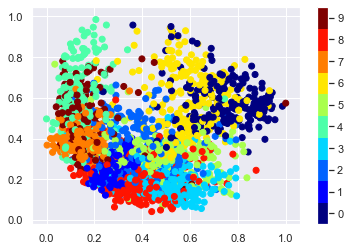

In [117]:
plt.scatter(proj[:, 0], proj[:, 1], c=target,  cmap=plt.cm.get_cmap('jet', 10)) 
plt.colorbar(ticks=range(10)) 
plt.clim(-0.5, 9.5);


In [127]:
# точки слишком близко
# посмотрим по одной цифре
from sklearn.manifold import Isomap
# Выбираем для проекции 1/4 цифр "1"        
data = mnist.data[mnist.target == '1'][::4]

In [128]:
np.unique(mnist.target)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

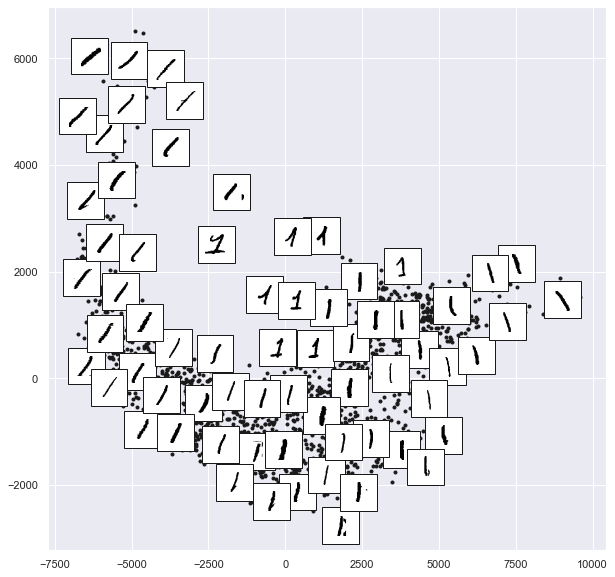

In [129]:
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)), ax=ax, thumb_frac=0.05, cmap='gray_r')